In [1]:
from scipy.optimize import ridder
import torch
import matplotlib.pyplot as plt
from Gibbs import generate_sw_tuples_batch
from MINE import MINE
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np
from Sample_Gibbs_from_Gaussian import sample_w
import random
import os
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
seed_torch()

p_current = 4 #p值
sample_size = 50000 #用来估计的样本数
iter_size = 10000
model = MINE(6, p_current)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []



100%|██████████| 3000/3000 [1:43:17<00:00,  2.07s/it]


array(0.1305006, dtype=float32)

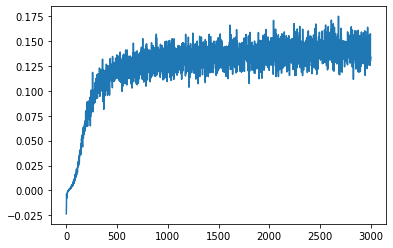

In [2]:
################################################################
original_random_state = np.random.get_state()
np.random.seed(20230929)
#gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
#teacher model
#dimension of x: d（固定不变）10->5
d = 5
#number of training samples（固定不变）100->20
N = 20
#dimension of hypothesis space
p0 = 5 #dimension of teacher model（固定不变）
p = p_current #dimension of student model（可变）#p=200
p_max = 2000 #upper bound of dimension of student model（固定不变）
#point-wise activate function f:tanh
#variance of random noise added to y
sigma = 0.1

#random feature matrix
F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
F = np.random.normal(0,1,(d,p_max))[:,:p] #生成student model的random feature matrix F(d*p)。先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
    #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
#teacher parameter w(p) with lambda = ? until each dim of Y~1e0
lambda_ = 0.0001
#w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
#w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)

np.random.set_state(original_random_state)
################################################################
#自定义数值求解函数 done
def solve_f_star(y):
    x = []
    for y_ in y[:,0]:
        y_ = y_.item()
        def f_star(x):
            return np.log(x)-1/(x+1e-12)+1-y_
        res = ridder(f_star,0,1 if y_<0 else np.exp(y_)+1,xtol=1e-12)
        x.append(res)
    return torch.tensor(x, requires_grad=False)

skl = []
num_epoch = 3000
for epoch in tqdm(range(num_epoch)):
    w = []
    S = []
    for i in range(iter_size):
        X = np.random.normal(0,1,(N,d))
        X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
        Y_pure = X_rf0.dot(w_0)
        Y = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y
        S_i = np.concatenate((X,Y.reshape(N,-1)),axis=1)[0]  #S=(X,Y)[0]
        B = np.tanh(X.dot(F)/np.sqrt(d))
        w_i = sample_w(p,N,10000,0.05,B,Y,1)[0]
        w.append(w_i)
        S.append(S_i)
    w = np.array(w)
    S = np.array(S)
    w_shuffle = np.random.permutation(w)
    S_sample = Variable(torch.from_numpy(S).type(torch.FloatTensor), requires_grad=True)
    w_sample = Variable(torch.from_numpy(w).type(torch.FloatTensor), requires_grad=True)
    w_shuffle_sample = Variable(torch.from_numpy(w_shuffle).type(torch.FloatTensor), requires_grad=True)
    pred_xy = model(S_sample, w_sample)
    pred_x_y = model(S_sample, w_shuffle_sample)
    
    loss1 = - torch.mean(pred_xy)
    t1 = solve_f_star(pred_x_y).reshape((-1,1))
    loss2 = torch.mean(t1*pred_x_y)
    loss2_actual = torch.mean(t1-1+torch.log(t1))
    loss = loss1 + loss2
    skl.append((-loss1-loss2_actual).data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

x_plot = [x for x in range(num_epoch)]
plt.plot(x_plot, skl)
################################################################################################
import json
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
with open("skl_result/p=4_gaussian_size=64.json", "w") as outfile:
    outfile.write(json.dumps(skl,cls=NumpyArrayEncoder))
################################################################################################
skl[len(skl)-1]

In [3]:
np.mean(skl[2000:])

0.14068325